In [1]:
import roboticstoolbox as rbt
from spatialmath import *
import numpy as np

In [2]:
pi = np.pi

In [3]:
# 3R-R-3R
human_arm = rbt.DHRobot([
        rbt.RevoluteMDH(alpha = pi/2), #joint 1
        rbt.RevoluteMDH(alpha = pi/2, offset = pi/2), #joint 2
        rbt.RevoluteMDH(alpha = -pi/2, offset = -pi/2), #joint 3
        rbt.RevoluteMDH(a = 0.4, alpha = -pi/2, offset = -pi/2), #joint 4
        rbt.RevoluteMDH(alpha = -pi/2, d = 0.4), #joint 5
        rbt.RevoluteMDH(alpha = pi/2, offset = pi/2), #joint 6
        rbt.RevoluteMDH(alpha = pi/2), #joint 7
    ],
    name = "Human Arm"
)
human_arm

DHRobot: Human Arm, 7 joints (RRRRRRR), dynamics, modified DH parameters
┌──────┬────────┬───────────┬─────┐
│ aⱼ₋₁ │  ⍺ⱼ₋₁  │    θⱼ     │ dⱼ  │
├──────┼────────┼───────────┼─────┤
│  0.0 │  90.0° │        q1 │ 0.0 │
│  0.0 │  90.0° │  q2 + 90° │ 0.0 │
│  0.0 │ -90.0° │  q3 - 90° │ 0.0 │
│  0.4 │ -90.0° │  q4 - 90° │ 0.0 │
│  0.0 │ -90.0° │        q5 │ 0.4 │
│  0.0 │  90.0° │  q6 + 90° │ 0.0 │
│  0.0 │  90.0° │        q7 │ 0.0 │
└──────┴────────┴───────────┴─────┘

┌──┬──┐
└──┴──┘

# MoveJ mode

## Forward Kinematics

In [13]:
q = [0,0,0,0,0,0,0]

In [14]:
T_0e = human_arm.fkine(q)
T_0e

   0         0        -1         0         
   0        -1         0         0         
  -1         0         0        -0.8       
   0         0         0         1         


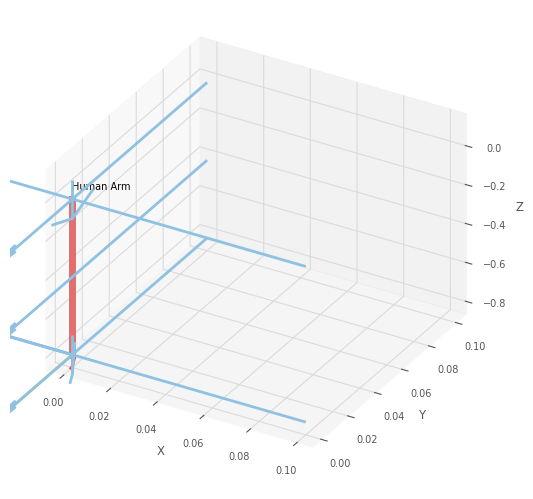

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Human Arm')

<Figure size 640x480 with 0 Axes>

In [15]:
human_arm.plot(q)

## Invert Kinematics

In [4]:
T_goal = SE3(0.2,0,-0.5) @ SE3.Rx(pi/2)
T_goal

   1         0         0         0.2       
   0         0        -1         0         
   0         1         0        -0.5       
   0         0         0         1         


In [5]:
q_sol = human_arm.ikine_LM(T_goal)
q_sol

IKSolution(q=array([-1.59706309, -0.63476078,  2.19908326,  1.66468428, -2.46800027,
       -2.43210332, -1.4718376 ]), success=True, iterations=11, searches=1, residual=4.701717041925406e-08, reason='Success')

In [20]:
q_sol.q

array([ 2.82406623, -0.65630916, -2.26242575, -1.57079633,  0.69162943,
        0.65630916,  0.31752642])

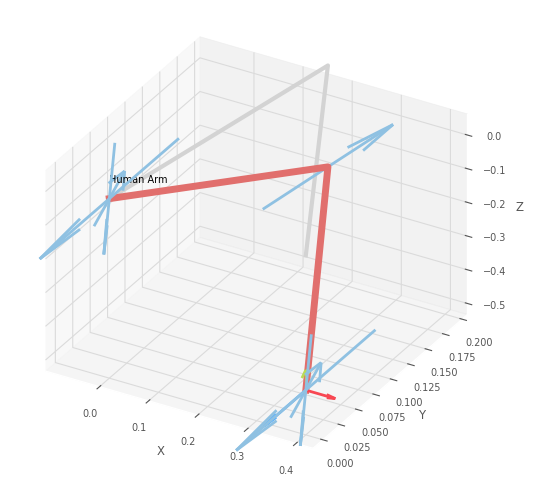

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Human Arm')

<Figure size 640x480 with 0 Axes>

In [21]:
human_arm.plot(q_sol.q)

# MoveL mode

## Velocity calculation

In [23]:
current_q = [0,0,0,0,0,0,0]
current_q

[0, 0, 0, 0, 0, 0, 0]

### Forward Kinematics

In [24]:
current_pos = human_arm.fkine(current_q)
current_pos

   0         0        -1         0         
   0        -1         0         0         
  -1         0         0        -0.8       
   0         0         0         1         


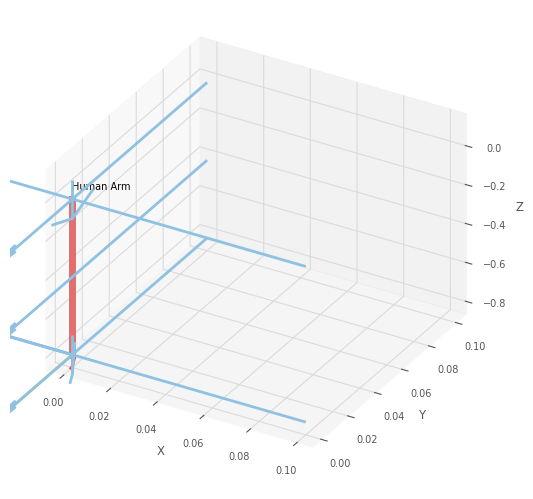

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Human Arm')

<Figure size 640x480 with 0 Axes>

In [25]:
human_arm.plot(current_q)

### Target direction 

In [26]:
target = [0.4,0,-0.4,0,0,0]
target

[0.4, 0, -0.4, 0, 0, 0]

In [27]:
current_pos.rpy()[0]

0.0

In [28]:
target_direction = [
    target[0] - current_pos.x,
    target[1] - current_pos.y,
    target[2] - current_pos.z,
    target[3] - current_pos.rpy()[0], # roll
    target[4] - current_pos.rpy()[1], # pitch
    target[5] - current_pos.rpy()[2] # yall
]
target_direction

[0.39999999999999997,
 1.7145055188062946e-16,
 0.4,
 0.0,
 -1.5707963267948966,
 3.141592653589793]

In [29]:
linear_size = np.sqrt(target_direction[0]**2 + target_direction[1]**2 + target_direction[2]**2)
linear_size

0.565685424949238

In [30]:
angular_size = np.sqrt(target_direction[3]**2 + target_direction[4]**2 + target_direction[5]**2)
angular_size

3.5124073655203634

In [31]:
unit_target_direction =[
    target_direction[0] / linear_size,
    target_direction[1] / linear_size,
    target_direction[2] / linear_size,
    target_direction[3] / angular_size,
    target_direction[4] / angular_size,
    target_direction[5] / angular_size,
]
unit_target_direction

[0.7071067811865475,
 3.030846196824227e-16,
 0.7071067811865476,
 0.0,
 -0.4472135954999579,
 0.8944271909999159]

In [32]:
vel = [
    unit_target_direction[0] * 0.5,
    unit_target_direction[1] * 0.5,
    unit_target_direction[2] * 0.5,
    unit_target_direction[3] * 0.5,
    unit_target_direction[4] * 0.5,
    unit_target_direction[5] * 0.5,
]

## Jacobian

In [33]:
J = human_arm.jacob0(current_q)
J

array([[ 8.00000000e-01, -7.34788079e-17,  4.89858720e-17,
         4.00000000e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.01148331e-32, -7.34788079e-17, -8.00000000e-01,
         8.13890448e-33,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 7.34788079e-17,  8.99855870e-33,  1.71450552e-16,
         4.89858720e-17,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.23259516e-32,  0.00000000e+00, -1.00000000e+00,
         0.00000000e+00,  1.22464680e-16,  0.00000000e+00,
        -1.00000000e+00],
       [-1.00000000e+00, -1.22464680e-16, -6.12323400e-17,
        -1.00000000e+00, -2.44929360e-16, -1.00000000e+00,
        -6.12323400e-17],
       [ 6.12323400e-17, -1.00000000e+00, -6.12323400e-17,
         1.83697020e-16, -1.00000000e+00,  1.83697020e-16,
        -6.12323400e-17]])

In [34]:
Jt = J.transpose()
Jt

array([[ 8.00000000e-01,  1.01148331e-32,  7.34788079e-17,
         1.23259516e-32, -1.00000000e+00,  6.12323400e-17],
       [-7.34788079e-17, -7.34788079e-17,  8.99855870e-33,
         0.00000000e+00, -1.22464680e-16, -1.00000000e+00],
       [ 4.89858720e-17, -8.00000000e-01,  1.71450552e-16,
        -1.00000000e+00, -6.12323400e-17, -6.12323400e-17],
       [ 4.00000000e-01,  8.13890448e-33,  4.89858720e-17,
         0.00000000e+00, -1.00000000e+00,  1.83697020e-16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.22464680e-16, -2.44929360e-16, -1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.00000000e+00,  1.83697020e-16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.00000000e+00, -6.12323400e-17, -6.12323400e-17]])

In [35]:
Jit = np.linalg.inv(np.dot(J,J.transpose()))
Jit

array([[ 8.75000000e+01, -1.96875000e+02, -9.18632214e+17,
        -2.04737744e-14, -2.50000000e+00, -2.44929360e-15],
       [-1.96875000e+02,  4.62500000e+02,  2.14347517e+18,
        -1.25000000e+00,  8.75000000e+00,  4.89858720e-15],
       [-9.18632214e+17,  2.14347517e+18,  1.00016017e+34,
         2.22074740e+02,  4.08280984e+16,  2.37500000e+01],
       [-2.81544598e-14, -1.25000000e+00,  3.05698147e+02,
         1.00000000e+00,  1.19688058e-15,  7.65404249e-17],
       [-2.50000000e+00,  8.75000000e+00,  4.08280984e+16,
         8.55516783e-16,  1.00000000e+00,  0.00000000e+00],
       [ 6.50593612e-16, -2.33448296e-15, -1.00000000e+01,
         7.65404249e-17, -1.37772765e-16,  5.00000000e-01]])

In [36]:
J_new = np.dot(Jt,Jit)
J_new

array([[ 5.00000000e+00, -8.75000000e+00, -4.08280984e+16,
        -9.16749123e-16,  1.46549439e-14, -1.83697020e-16],
       [-5.74053187e-16,  1.03329574e-15,  5.00000000e+00,
         1.53080850e-17, -7.65404249e-17, -5.00000000e-01],
       [-2.47249082e-14, -1.25000000e+00,  2.99031188e+00,
        -1.11022302e-16,  4.16567887e-16,  4.59242550e-17],
       [-7.50000000e+00,  1.75000000e+01,  8.16561968e+16,
         1.83349825e-15, -2.76445533e-14,  2.75545530e-16],
       [-3.82702125e-17,  3.82702125e-17, -3.37507799e-14,
         4.59242550e-17, -1.07156595e-16, -5.00000000e-01],
       [ 2.50000000e+00, -8.75000000e+00, -4.08280984e+16,
        -8.55516783e-16, -1.00000000e+00,  9.18485099e-17],
       [ 2.83075406e-14,  1.25000000e+00, -3.08198147e+02,
        -1.00000000e+00, -1.25811292e-15, -1.07156595e-16]])

## Calculate q_dot

In [37]:
q_dot = np.dot(J_new,vel)
q_dot

array([-1.44349126e+16,  1.54416016e+00,  1.05723491e+00,  2.88698252e+16,
       -2.23606798e-01, -1.44349126e+16, -1.08964500e+02])

## Find singularity

In [39]:
import numpy as np
from scipy.linalg import svd

# Compute singular values
U, S, Vh = svd(J)
print("Singular values:", S)

# Check for near-zero singular values
if np.any(S < 1e-6):
    print("Jacobian is near singular.")
else:
    print("Jacobian is non-singular.")


Singular values: [1.87826571e+00 1.53946497e+00 1.41421356e+00 5.21649250e-01
 5.19661063e-01 1.59186624e-17]
Jacobian is near singular.


## Calculate joint effort

In [27]:
w = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
w

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [29]:
t = np.dot(J.transpose(),w)
t

array([-2.57405257, -6.9258615 ,  1.35180893, -4.31208182,  1.06741805,
       -0.39815702, -1.3046416 ])